# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Much of the code and data pre-processing has already been done for you. Additionally, notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

**-------------------------------------------------------------------------------------------------------------**

There are 2 types of tasks in this assignment: 
- coding tasks --- 10 tasks worth 1 point each --- asking you to write code following specifications provided; make sure to <ins>show the code to your teacher after completing every coding task</ins>
- interpretation questions --- 5 questions worth 1 point each --- asking you to interpret the data or the results of the model

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life), as well as self-check regularly by printing your tensors and their shapes making sure they look adequate.

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics. 

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word. 

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">he</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, please talk to your teacher)

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 103, "said": 97, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 103 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [1]:
import pickle
import torch
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List

import torch.nn as nn 
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
with open("output.p", "rb") as f:
    vocab, contexts, X = pickle.load(f) 
    
# Notes for self
# ten words (will only print the key; not the value (id in this case))
print(list(vocab)[:10])
print(type(contexts['flavor']))
print(type(contexts['flavor'].items()))

['flavor', 'party', 'mistress', 'new', 'weird', 'pots', 'prodding', 'apparated', 'pressing', 'alastor']
<class 'collections.Counter'>
<class 'dict_items'>


Let's inspect the summed context of the word 'portrait'.

In [3]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)

[('harry', 103),
 ('said', 97),
 ('hole', 84),
 ('ron', 49),
 ('hermione', 46),
 ('room', 41),
 ('t', 40),
 ('fat', 39),
 ('lady', 39),
 ('common', 30),
 ('dumbledore', 26),
 ('phineas', 24),
 ('climbed', 22),
 ('just', 19),
 ('swung', 17),
 ('sirius', 17),
 ('professor', 17),
 ('time', 16),
 ('voice', 15),
 ('open', 15),
 ('got', 15),
 ('nigellus', 15),
 ('reached', 14),
 ('like', 14),
 ('came', 14),
 ('little', 14),
 ('gryffindor', 13),
 ('turned', 13),
 ('forward', 12),
 ('don', 12),
 ('long', 12),
 ('place', 12),
 ('wall', 11),
 ('neville', 11),
 ('black', 11),
 ('going', 11),
 ('snape', 11),
 ('hall', 11),
 ('mcgonagall', 11),
 ('corridor', 10),
 ('walked', 10),
 ('away', 10),
 ('ve', 10),
 ('way', 10),
 ('visit', 10),
 ('good', 10),
 ('did', 10),
 ('look', 10),
 ('password', 9),
 ('moment', 9),
 ('know', 9),
 ('sir', 9),
 ('opened', 9),
 ('face', 9),
 ('heard', 9),
 ('come', 8),
 ('gone', 8),
 ('asked', 8),
 ('let', 8),
 ('really', 8),
 ('entrance', 8),
 ('cadogan', 8),
 ('mother

How about the word 'ghost'?

In [4]:
sorted([(item, value) for item, value in contexts["ghost"].items()], key=lambda x: x[1], reverse=True)

[('harry', 52),
 ('said', 36),
 ('nick', 22),
 ('t', 20),
 ('nearly', 20),
 ('headless', 18),
 ('know', 15),
 ('looked', 12),
 ('ron', 10),
 ('saw', 9),
 ('d', 9),
 ('ve', 9),
 ('got', 8),
 ('gryffindor', 8),
 ('years', 7),
 ('bloody', 7),
 ('baron', 7),
 ('wand', 7),
 ('cedric', 7),
 ('dumbledore', 7),
 ('just', 6),
 ('don', 6),
 ('think', 6),
 ('told', 6),
 ('slytherin', 6),
 ('staring', 6),
 ('eyes', 6),
 ('professor', 6),
 ('passed', 6),
 ('like', 6),
 ('hermione', 6),
 ('gray', 6),
 ('ruff', 5),
 ('suddenly', 5),
 ('table', 5),
 ('potter', 5),
 ('giving', 5),
 ('began', 5),
 ('tower', 5),
 ('magic', 5),
 ('binns', 5),
 ('light', 5),
 ('held', 5),
 ('head', 5),
 ('little', 5),
 ('solid', 5),
 ('really', 4),
 ('hufflepuff', 4),
 ('hat', 4),
 ('opposite', 4),
 ('seen', 4),
 ('arm', 4),
 ('need', 4),
 ('sir', 4),
 ('gaunt', 4),
 ('face', 4),
 ('silver', 4),
 ('corridor', 4),
 ('covered', 4),
 ('wide', 4),
 ('oh', 4),
 ('asked', 4),
 ('away', 4),
 ('myrtle', 4),
 ('hair', 4),
 ('thing'

In [5]:
sorted([(item, value) for item, value in contexts["harry"].items()], key=lambda x: x[1], reverse=True)

[('said', 11682),
 ('t', 5489),
 ('ron', 5375),
 ('hermione', 4301),
 ('dumbledore', 2497),
 ('looked', 2085),
 ('did', 1792),
 ('know', 1717),
 ('just', 1654),
 ('like', 1516),
 ('hagrid', 1512),
 ('got', 1453),
 ('looking', 1418),
 ('ve', 1394),
 ('d', 1391),
 ('don', 1348),
 ('snape', 1331),
 ('eyes', 1311),
 ('potter', 1292),
 ('right', 1278),
 ('time', 1277),
 ('think', 1261),
 ('face', 1230),
 ('wand', 1204),
 ('look', 1134),
 ('professor', 1105),
 ('didn', 1087),
 ('going', 1084),
 ('saw', 1079),
 ('voice', 1070),
 ('come', 1067),
 ('door', 1042),
 ('thought', 1022),
 ('malfoy', 1010),
 ('m', 993),
 ('head', 971),
 ('room', 956),
 ('weasley', 953),
 ('asked', 948),
 ('hand', 941),
 ('sirius', 918),
 ('voldemort', 908),
 ('himself', 884),
 ('knew', 877),
 ('turned', 867),
 ('away', 819),
 ('felt', 815),
 ('way', 808),
 ('told', 786),
 ('good', 785),
 ('heard', 752),
 ('tell', 740),
 ('want', 736),
 ('mr', 728),
 ('let', 728),
 ('left', 721),
 ('moment', 718),
 ('yeah', 702),
 ('o

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow along the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content. 

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### Sparsity and Stability

Our matrix $X$ is very sparse; most of its elements are zero.

**Coding 1.1**: Find what the ratio of non-zero elements is.

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [6]:
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
    zeros = np.count_nonzero(sparse_matrix == 0)
    nonzeros = np.count_nonzero(sparse_matrix != 0) 
    return nonzeros / (nonzeros + zeros)

In [7]:
non_zero_ratio(X)
type(non_zero_ratio(X))#Nonzero ratio is 0.108 with roughly ~10% nonzeros
print('Zero ratio in the input matrix is {}'.format(non_zero_ratio(X)))

Zero ratio in the input matrix is 0.108448515107535


We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements. 

**Coding 1.2**: Change the matrix's datatype to a `torch.float` and add a small constant to it (e.g. $0.1$) to ensure numerical stability while maintaining sparsity.

In [8]:
X = X.to(torch.float) + 0.1
print(X)

tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### From co-occurrence counts to probabilities
From the paper: 
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appear in the context of word $i$. 

**Coding 2**: Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$. 

_Hint_: Remember broadcasting and `torch.sum()`.

In [9]:
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
    return count_matrix/torch.sum(count_matrix, dim = 1).unsqueeze(1)

In [10]:
P = to_probabilities(X)
print(P)

tensor([[1.2439e-04, 1.2439e-04, 1.2439e-04,  ..., 1.2439e-04, 1.2439e-04,
         1.2439e-04],
        [4.5067e-05, 4.5067e-05, 4.5067e-05,  ..., 4.5067e-05, 4.5067e-05,
         4.5067e-05],
        [9.7191e-05, 9.7191e-05, 9.7191e-05,  ..., 9.7191e-05, 9.7191e-05,
         9.7191e-05],
        ...,
        [1.3177e-04, 1.3177e-04, 1.3177e-04,  ..., 1.3177e-04, 1.3177e-04,
         1.3177e-04],
        [1.1602e-04, 1.1602e-04, 1.1602e-04,  ..., 1.1602e-04, 1.1602e-04,
         1.1602e-04],
        [7.0328e-05, 7.0328e-05, 7.0328e-05,  ..., 7.0328e-05, 7.0328e-05,
         7.0328e-05]])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

**Coding 3.1**: Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$.

In [11]:
def query(word_i: str, word_j: str, vocab: Dict[str, int], probability_matrix: FloatTensor) -> float:  
    i = vocab[word_i]
    j = vocab[word_j]
    
    return probability_matrix[i][j].item()

**Coding 3.2**: Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$.

In [12]:
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], probability_matrix: FloatTensor) -> float:
    Pik = query(word_i, word_k, vocab, probability_matrix)
    Pjk = query(word_j, word_k, vocab, probability_matrix)
    
    return Pik / Pjk

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. Feel free to add your own word triplets and experiment.

In [13]:
print("tea", "wand", "spell", probe("tea", "wand", "spell", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()

print("voldemort", "hagrid", "curse", probe("voldemort", "hagrid", "curse", vocab, P))
print("voldemort", "hagrid", "beast", probe("voldemort", "hagrid", "beast", vocab, P))
print()

print("mcgonagall", "snape", "potions", probe("mcgonagall", "snape", "potions", vocab, P))
print("mcgonagall", "snape", "transfiguration", probe("mcgonagall", "snape", "transfiguration", vocab, P))
print()

print("hedwig", "scabbers", "owl", probe("hedwig", "scabbers", "owl", vocab, P))
print("hedwig", "scabbers", "rat", probe("hedwig", "scabbers", "rat", vocab, P))
print()

print("ron", "hermione", "book", probe("ron", "hermione", "book", vocab, P))
print("ron", "hermione", "red", probe("ron", "hermione", "red", vocab, P))
print()

print("ron", "hermione", "2015", probe("ron", "hermione", "2015", vocab, P))
print("ron", "hermione", "gryffindor", probe("ron", "hermione", "gryffindor", vocab, P))
print()

tea wand spell 0.42263388565501575
tea wand cup 24.61305850905283

voldemort hagrid curse 8.710822275728288
voldemort hagrid beast 0.5588329163940012

mcgonagall snape potions 0.0036196233324942884
mcgonagall snape transfiguration 43.71879996208764

hedwig scabbers owl 5.626579680798838
hedwig scabbers rat 0.017819204280628394

ron hermione book 0.6783071504063404
ron hermione red 2.0382548360401223

ron hermione 2015 0.8539477180887408
ron hermione gryffindor 1.1493178255355085



**Interpretation 1**: Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

**Answer 1**: For a word **k** related to **i** but not **j**, $\frac{P_{ik}}{P_{jk}}$ will be large. In the code above $\frac{P(tea, cup)}{P(wand, cup)}$ is 2.639, because the nominator is very large (many coocurances for 'tea' and 'cup'), while the denominator is small (few coocurances for 'wand' and 'cup'). Similarly, for words **k** related to **j** but not **i** the ratio should be small; here $\frac{P(tea, spell)}{P(wand, spell)}$ is 0.0476, becasue the nominator is small (few or no coocurances for 'tea' and 'spell'), while the denominator is very large.


For words **k** like 'gryffindor' or '2015', that are either related to both **i** (ron) and **j** (hermione), or to neither, the ratio should be close to one (which is the case as shown by the ratio's 1 and 1.34).

What would happen if we tried probing out-of-domain words? Use the words that the authors report in the paper as discriminative for "ice" and "steam".

In [14]:
word1 = "solid"
word2 = "gas"
print("ice", "steam", word1, probe("ice", "steam", word1, vocab, P))
print("ice", "steam", word2, probe("ice", "steam", word2, vocab, P))

ice steam solid 0.08204092670683832
ice steam gas 0.9024501648386338


**Interpretation 2**: Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

**Answer 2:**: The authors of the GloVe paper find a large ratio for ice, steam, solid and a low ratio for ice, steam, gas. This is however not the case for this corpus. The coocurance of words depend on the theme of the corpus, hence probing out-of-domain words (such as the thermodynamics example) does not return the same results as the authors because they probed a completely different corpus. This might eb due to 2 reasons:

* **Corpus context**: The theme of a text determines the context of a word with respect to other words. In a textbook about thermodynamics *ice* would co-occur more often with *solid* due to the context it is written in - laws of physics, while in a book about nature, *ice* would occur more often in the context of boreal or alpine landscapes and the word *solid*  would probaly be rarely mentioned, if at all, since it would not really fit the theme of the book (and when occuring it would occur in a different context, such as a *solid* rock). 
* **Word frequency**: These out-of-domain examples are probably few in general for the HP corpus. Therefore they do not occur in the expected context very often, which leads to a ratio closer to one. This small sample size might result in a sample error: there are far to few instances of the words present in the test and rather coocur by chance with other words (far-related, or non-related words) To get somewhat more sensible results more instances  of those words are necessary. 

Concluding, similar results would be more likely if J.K. Rowling had written about a class about "the defense against the dark, but still very much according to the laws of physics, thermodynamics" instead of "the defense against the dark arts classes". Steam would in that case probably co-occur more often with gas than with solid. Or if the corpus would be extended with books about the states of matter. The co-occurrences between ice and steam would then probably be more like the examples from the authors. 

## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones. 

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as 

$f: \mathbb{R} \to \mathbb{R} = \begin{cases}
    (x/x_{max})^\alpha, & \text{if $x<x_{max}$}\\
    1, & \text{otherwise}.
  \end{cases}$

### Weighting Function

Let's start with the last part. 

**Coding 4**: Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X_weighted}$, the matrix ${X}$ after weighting, using the paper's suggested parameters. 

_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise.

In [15]:
def weight_fn(X: FloatTensor, x_max: int, a: float) -> FloatTensor:
    X_adj = (X/x_max)**a
    X_ones = torch.ones_like(X)
    X_weighted = torch.where(X < x_max, X_adj, X_ones)
    return X_weighted

In [16]:
X_weighted = torch.tensor(weight_fn(X, x_max=100, a=0.75)).to(torch.float)
print(X_weighted)

tensor([[0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        ...,
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056],
        [0.0056, 0.0056, 0.0056,  ..., 0.0056, 0.0056, 0.0056]])


C:\Users\DK\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X_weighted}$ to get a better idea. 

In [17]:
"""
print("tea", "wand", "spell", probe("tea", "wand", "spell", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()
"""

'\nprint("tea", "wand", "spell", probe("tea", "wand", "spell", vocab, P))\nprint("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))\nprint()\n'

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Loss Function

Next step is to write the loss function. 

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient. 

Inspecting the formulation of $J$, it is fairly straight-forward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

**Coding 5**: Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$. 

In [18]:
def loss_fn(
    X_weighted: FloatTensor, 
    W: FloatTensor, 
    W_context: FloatTensor, 
    B: FloatTensor, 
    B_context: FloatTensor, 
    X: FloatTensor
) -> FloatTensor:
    
    WW = torch.mm(W, W_context.T)
    LX = torch.log(X)
    return (X_weighted *(WW + B + B_context.T - LX)**2).sum()

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors. 

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/nn.html#embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. 

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. **Coding 6.1**: Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. **Coding 6.2**: Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. **Coding 7**: Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [19]:
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dimensionality: int=30, device: str='cpu') -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        self.w = nn.Embedding(self.vocab_len, vector_dimensionality).to(device)
        self.wc = nn.Embedding(self.vocab_len, vector_dimensionality).to(device)
        self.b = nn.Embedding(self.vocab_len, 1).to(device)
        self.bc = nn.Embedding(self.vocab_len, 1).to(device)
        
    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        WC = self.wc(embedding_input)
        B = self.b(embedding_input)
        BC = self.bc(embedding_input)
        
        J = loss_fn(X_weighted, W, WC, B, BC, X)
        return J
    
    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        WC = self.wc(embedding_input)
        W_WC = W + WC
        return W_WC

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign). 

**Coding 8.1**: Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs.

When writing the training script, remember that your network's forward pass is __already__ computing the loss.

In [20]:
network = GloVe(vocab, 30)
opt = optim.Adam(network.parameters(), lr = 0.05)

In [21]:
num_epochs = 301
losses = []
for i in range(num_epochs):
    loss = network.forward(X_weighted, X) # loss computation 
    loss.backward() # gradient computation
    opt.step() # back-propagation
    opt.zero_grad() # gradient reset
    losses.append(loss)
    if i%10 == 0:
        print('Iteration {} loss: {}'.format(i,  loss.item()))

Iteration 0 loss: 11891599.0
Iteration 10 loss: 3183803.25
Iteration 20 loss: 1180905.625
Iteration 30 loss: 571355.25
Iteration 40 loss: 412136.6875
Iteration 50 loss: 356657.5625
Iteration 60 loss: 332617.1875
Iteration 70 loss: 320195.625
Iteration 80 loss: 311718.0625
Iteration 90 loss: 304695.34375
Iteration 100 loss: 298673.0625
Iteration 110 loss: 293585.5625
Iteration 120 loss: 289280.25
Iteration 130 loss: 285644.53125
Iteration 140 loss: 282590.3125
Iteration 150 loss: 280019.65625
Iteration 160 loss: 277837.75
Iteration 170 loss: 275964.71875
Iteration 180 loss: 274340.40625
Iteration 190 loss: 272916.3125
Iteration 200 loss: 271655.90625
Iteration 210 loss: 270527.78125
Iteration 220 loss: 269506.875
Iteration 230 loss: 268573.59375
Iteration 240 loss: 267713.96875
Iteration 250 loss: 266916.90625
Iteration 260 loss: 266174.25
Iteration 270 loss: 265479.8125
Iteration 280 loss: 264828.375
Iteration 290 loss: 264215.125
Iteration 300 loss: 263637.0


**Coding 8.2**: Plot the losses and examine the learning curve. Is its shape what you would expect it to be?

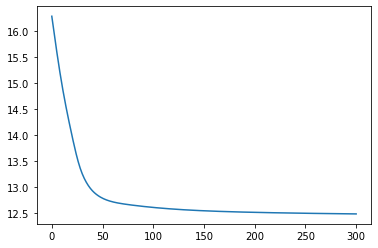

In [22]:
plt.plot(np.arange(0,num_epochs,1), np.log(losses)); 

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment. 

We will check which words the models considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high dimensional vector spaces is the cosine similarity. 

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words.

In [23]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    i = vocab[word_i]
    j = vocab[word_j] 
    v_i = vectors[i] / torch.norm(vectors[i], p=2)  # a/|a|
    v_j = vectors[j] / torch.norm(vectors[j], p=2)  # b/|b|
    sim = torch.mm(v_i.view(1, -1), v_j.view(-1, 1)).item()
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs:

In [24]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"), 
    ("avada", "kedavra"), 
    ("hogwarts", "school"), 
    ("goblin", "hagrid"), 
    ("giant", "hagrid"),
    ("avada", "spell"),
    ("kedavra", "spell"),
    ("tea", "spell"),
    ("flavor", "spell"),
]:
    
    print("Similarity between '{}' and '{}' is: {}".
          format(pair[0], pair[1], similarity(pair[0], pair[1], vocab, word_vectors)))
    
# Similarity between 'cruciatus' and 'imperius' is: 0.6526349782943726
# Similarity between 'avada' and 'kedavra' is: 0.8372835516929626
# Similarity between 'hogwarts' and 'school' is: 0.5365726947784424
# Similarity between 'goblin' and 'hagrid' is: 0.006154807284474373
# Similarity between 'giant' and 'hagrid' is: 0.6696826815605164
# Similarity between 'avada' and 'spell' is: 0.5213215947151184
# Similarity between 'kedavra' and 'spell' is: 0.42069360613822937
# Similarity between 'tea' and 'spell' is: -0.18944574892520905
# Similarity between 'flavor' and 'spell' is: -0.2212987095117569

Similarity between 'cruciatus' and 'imperius' is: 0.6526349782943726
Similarity between 'avada' and 'kedavra' is: 0.8372835516929626
Similarity between 'hogwarts' and 'school' is: 0.5365726947784424
Similarity between 'goblin' and 'hagrid' is: 0.006154807284474373
Similarity between 'giant' and 'hagrid' is: 0.6696826815605164
Similarity between 'avada' and 'spell' is: 0.5213215947151184
Similarity between 'kedavra' and 'spell' is: 0.42069360613822937
Similarity between 'tea' and 'spell' is: -0.18944574892520905
Similarity between 'flavor' and 'spell' is: -0.2212987095117569


**Interpretation 3**: Give a brief interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

**Answer 3:** The results are reasonable, both avada and kedavra are expected to be very similar, since they are both part of a spell and therefore almost always co-occur in succession. Similarly, hogwarts and school should be relatively similar in this corpus, since hogwarts is one school of wizards and is almost always followed by the word school. Also, hagrid and giant are similar, because hagrid is large, not small like a goblin and also does not look like one.
Unlike "avada" and "kedavra", that are similar to the word 'spell' (since both are part of a spell), "tea" and "spell" or "flavor" and "spell" are not conceptually (or semantically) related to spell. However they are also not conceptually inversed, thus dissimilar (the complete opposite, such as antonyms). Hence their value should be close to 0.

To obtain the similarities of one word against all other words in the corpus, we may rewrite the above equation as:
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2}$$

**Coding 9**: Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus.

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [25]:
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    i = vocab[word_i]
    v_w = vectors[i] / torch.norm(vectors[i], p=2)  # w/|w|
    v_C = vectors / torch.norm(vectors, p=2)  # C/|C|
    sim = torch.mm(v_w.view(1, -1), v_C.permute(1, 0))
    return sim  

In [26]:
print("Similarity between '{}' and the corpus is: {}".format("hagrid", similarities("hagrid", vocab, word_vectors)))

Similarity between 'hagrid' and the corpus is: tensor([[ 0.0005,  0.0063,  0.0019,  ..., -0.0020, -0.0025,  0.0030]])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [27]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i]

In [34]:
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print("Most similar words to '{}': {}".format(word, most_similar(word, vocab, word_vectors, 7)))
    
# Results:
# Most similar words to 'forbidden': ['forest', 'buckbeak', 'madame', 'students', 'spiders', 'maxime']
# Most similar words to 'myrtle': ['moaning', 'bathroom', 'toilet', 'tank', 'sorting', 'water']
# Most similar words to 'gryffindor': ['slytherin', 'team', 'ravenclaw', 'bludger', 'quidditch', 'points']
# Most similar words to 'wand': ['harry', 't', 'eyes', 'ron', 'just', 'said']
# Most similar words to 'quidditch': ['team', 'gryffindor', 'match', 'snitch', 'wood', 'got']
# Most similar words to 'marauder': ['map', 'nigellus', 'published', 'padfoot', 'pomfrey', 'portrait']
# Most similar words to 'horcrux': ['soul', 'godric', 'sword', 'bathilda', 'hallows', 'did']
# Most similar words to 'phoenix': ['feather', 'fawkes', 'wand', 'gaunt', 'ollivander', 'eyes']
# Most similar words to 'triwizard': ['tournament', 'champions', 'cup', 'beauxbatons', 'madame', 'bagman']
# Most similar words to 'screaming': ['light', 'supporters', 'death', 'expecto', 'eater', 'himself']
# Most similar words to 'letter': ['envelope', 'hedwig', 'owls', 'owl', 'ripped', 'quill']

Most similar words to 'forbidden': ['forest', 'buckbeak', 'madame', 'students', 'spiders', 'maxime']
Most similar words to 'myrtle': ['moaning', 'bathroom', 'toilet', 'tank', 'sorting', 'water']
Most similar words to 'gryffindor': ['slytherin', 'team', 'ravenclaw', 'bludger', 'quidditch', 'points']
Most similar words to 'wand': ['harry', 't', 'eyes', 'ron', 'just', 'said']
Most similar words to 'quidditch': ['team', 'gryffindor', 'match', 'snitch', 'wood', 'got']
Most similar words to 'marauder': ['map', 'nigellus', 'published', 'padfoot', 'pomfrey', 'portrait']
Most similar words to 'horcrux': ['soul', 'godric', 'sword', 'bathilda', 'hallows', 'did']
Most similar words to 'phoenix': ['feather', 'fawkes', 'wand', 'gaunt', 'ollivander', 'eyes']
Most similar words to 'triwizard': ['tournament', 'champions', 'cup', 'beauxbatons', 'madame', 'bagman']
Most similar words to 'screaming': ['light', 'supporters', 'death', 'expecto', 'eater', 'himself']
Most similar words to 'letter': ['envelope

**Interpretation 4**: Interpret the results.
- Do these most similar words make sense (are they actually similar to the query words)? 
- Are there any patterns you can see in the "errors" (the words that you woudn't consider actually similar to the query word)? 
- Would you say that the model captures similarity, relatedness, both or neither?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

**Answer 4:** 
**(1)** On face value, some categories have extreme good matches, such as the results for: 
* (1) letter ['envelope', 'hedwig', 'owls', 'owl', 'ripped', 'quill'], since both quill and evelope are generally related to the concept of letter, and hedweig and owls are specifically related to it in the context of the HP books
* (2) Gryffindor: ['slytherin', 'team', 'ravenclaw', 'bludger', 'quidditch', 'points'], since the other houses (slythernin, ravenclaw) are fairy similiar conceptually, while aspects of quidditch (Quidditch, points, team) are more strongly related to Gryffindor, because they often engage in this activity with the other houses.
* (3) myrtle': ['moaning', 'bathroom', 'toilet', 'tank', 'sorting', 'water'], where both moaning and bathroom related concepts (such as toilet and water) do often coocur in the context of myrte, but are rather related than similiar to her. 

The similarity/relatedness for other concepts such as marauder, screaming, and forbidden are more difficult to evaluate. This might be because HP-specific concepts such as Griffindor or Myrte have more HP-specific related words (Quidditch, Bathroom) rather than more general words (like in the case of wand). Some words might actually be related but this is hard to evaluate for HP novices and should rather be done by a true expert in this field, like Thimo's girlfriend.

**(2)** Some errors seem to occur, but it could also be that those words are related to the target word, but due to the lack of HP-knowledge we might not see their relationship. However,  words such as conjugations or often occuring verbs might co-occur a lot with a given concept but are conceptually neither related nor similar to it. Other words that are not in particularly related to a concept such as published and marauder might jut co-occur often enough for the model to assume that there might be a semantic relationship between them. In general the most similar words are strongly specific to the HP-corpus (e.g. Owl and letter might not necessarly be related to each other outside of the corpus). Lastly, since the book is strongly written from Harries percpetive (although its in a narrator view), Harry is often related to many concepts (due to the writing style favoring Harries perspective more than others).

**(3)** As mentioned before, many word pairs are related to each other rather than similar. Similarity is different from the general notion of relatedness:
* (1) Gryffindor - Quidditch are related (occur in the same contexts, more general relationship)
* (2) Gryffindor - Slytherin are similar (substitutable in many contexts, share properties)

In general, similarity is much harder to extract out of distributional spaces. Typically, related words occur in the same context as well as similar words. Again, the GloVe model is based on the paradigm of distributed semantics, and similarity in this context is a very broad notion. Relatedness will also be included in this paradigmn. Although some notion of similarity could be captured and possibly more whith additional processing, such as ‘retrofitting’, are introduced to the model.

Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word! 
(A compression ratio of 99.4%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space).
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as is $c$ to $?$" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

**Coding 10**: Write your own function that performs the word analogy task.

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [29]:
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int], vectors: FloatTensor, k: int
) -> List[str]:
    # Word vectors
    w_a = vectors[vocab[word_a]]
    w_b = vectors[vocab[word_b]]
    w_c = vectors[vocab[word_c]]
    w_d = w_b - w_a + w_c

    # Same as similarities
    w = w_d.unsqueeze(0) / torch.norm(w_d, p=2)
    C_m = vectors.T
    C = C_m / torch.norm(C_m, p=2, dim=0)
    sims = torch.mm(w, C)

    # Same as most similar
    _, topi = sims.topk(dim=-1, k=k)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_c]

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Some example triplets to test your analogies on:

In [30]:
triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron")
           ]

for a, b, c in triplets:
    print("'{}' is to '{}' as '{}' is to {}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 6)))

# Results:
# 'padma' is to 'parvati' as 'fred' is to ['aren', 'hang', 'bit', 'actually', 'started']
# 'avada' is to 'kedavra' as 'expecto' is to ['patronum', 'stag', 'dementor', 'vapor', 'sparks']
# 'dungeon' is to 'slytherin' as 'tower' is to ['slytherin', 'heir', 'championship', 'opposite', 'played']
# 'scabbers' is to 'ron' as 'hedwig' is to ['dear', 'ginny', 'horn', 'landed', 'heavily']
# 'ron' is to 'molly' as 'draco' is to ['narcissa', 'molly', 'runcorn', 'yaxley', 'nott', 'borgin']
# 'durmstrang' is to 'viktor' as 'beauxbatons' is to ['viktor', 'krum', 'locker', 'champions', 'applauding']
# 'snape' is to 'potions' as 'trelawney' is to ['divination', 'classroom', 'sprout', 'greenhouse', 'term']
# 'harry' is to 'seeker' as 'ron' is to ['seeker', 'chess', 'captain', 'teams', 'played', 'oliver']

'padma' is to 'parvati' as 'fred' is to ['aren', 'hang', 'bit', 'actually', 'started']
'avada' is to 'kedavra' as 'expecto' is to ['patronum', 'stag', 'dementor', 'vapor', 'sparks']
'dungeon' is to 'slytherin' as 'tower' is to ['slytherin', 'heir', 'championship', 'opposite', 'played']
'scabbers' is to 'ron' as 'hedwig' is to ['dear', 'ginny', 'horn', 'landed', 'heavily']
'ron' is to 'molly' as 'draco' is to ['narcissa', 'molly', 'runcorn', 'yaxley', 'nott', 'borgin']
'durmstrang' is to 'viktor' as 'beauxbatons' is to ['viktor', 'krum', 'locker', 'champions', 'applauding']
'snape' is to 'potions' as 'trelawney' is to ['divination', 'classroom', 'sprout', 'greenhouse', 'term']
'harry' is to 'seeker' as 'ron' is to ['seeker', 'chess', 'captain', 'teams', 'played', 'oliver']


Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

**Interpretation 5**: Interpret the results. 
- Did the model manage to guess the correct answers to the analogies (taking the first word in the output to be the model's "guess")? 
- Are the correct answers present in the top K words? 
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

**Answer 5** 
**(1)** The model is able to describe some analogies correctly: For example, 
* 'avada' is to 'kedavra' as 'expecto' is to 'patronum'. Both are aspects of spells.
* 'snape' is to 'potion' as 'trelaweny' is to 'divination'. Both are professors that teach within a certain field of magic.
* 'ron' is to 'molly' as 'draco' is to 'narcissa'. Both molly and narcissa are the mothers of ron and draco, respectively.
* 'harry' is to 'seeker' as 'ron' is to 'chess'. This is debateable, since the chess is not the one that the models considers as best match. Morover, in the context of quidditch ron would rather be the keeper (together with oliver), but in the context of skilledness or passion chess would be reasonable for ron. 

Yet following are wrong:
* 'dungeon' is to 'slytherin' and 'tower' is to... (is wrong), should be Griffindor (or another house).
* 'padma' is to 'parvati' as 'fred' is to... (is wrong, should be Ron, George, Bill (and two unknown) would be correct.
* 'durmstrang' is to 'viktor' as 'beauxbatons' is to ... (is wrong), should be Fleur.
* 'scabbers' is to 'ron' as 'hedwig' is to ... (is wrong), should be Harry.

**(2)** The four examples mentioned above has the correct answers present in the top 6 words, of which 3 are even considered as the best match. However none of the other examples contains the correct answer in the vector of words.

**(3)**  Asaformetioned, there are some factor that might hamper the models performance to understand similarity and relatedness between words. Those factors affect how word vectors are constructed and therefore those problems are passed on to the analysis of analogies. Three factors were mentioned in answer 3, namely, common coocurances, grammatical aspects and stopwords and a writing style favoring Harry's perspective (there are probably more challanges for this corpus or distributed semantics in general).

One error in the case of 'scabbers' is to 'ron' as 'hedwig' is to ... might give a cue why incorrect answers occur. Dear and Ginny are the models best guess, and they are strongly related to Hedwig and Harry, since Harry might often receive or send letter to Ginny via Hedwig. The same goes for 'harry' is to 'seeker' as 'ron' is to ... several very related words to ron/harry and quidditch occur that are even somewhat similar to rons role in quidditch, such as oliver (also keeper) and captain (another position/role of Harry), respectively. 

One common pattern often seems to arise from the analogies for specific word pairs, where sometimes the model returns the second pair of the first part of the analogy as the correct answer (like, $a$ is to $b$, as $c$ is to $b$). This is in particular the case when the loss is high during the first few epochs, some concepts "'avada' is to 'kedavra' as 'expecto' is to 'patronum'"are fairly fast figured out while others keep showing the errorlike pattern, indicating that the model did not unstand the semantic relationship between the words. The model might not arrive at the right word vector for $a$ and $b$, $w_d \approx w_b - w_a + w_c$, where $w_a + w_c$ are 0 and hence $w_d =w_b$.




### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, etc.). 

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?

In [53]:
network = GloVe(vocab, 70)
opt = optim.Adam(network.parameters(), lr = 0.1)
X_weighted = torch.tensor(weight_fn(X, x_max=100, a=0.85)).to(torch.float)
num_epochs = 301
losses = []

# qualitative test instances for similarity
word_pairs = [("cruciatus", "imperius"), 
            ("avada", "kedavra"), 
            ("hogwarts", "school"), 
            ("goblin", "hagrid"), 
            ("giant", "hagrid"),
            ("tea", "spell"),
            ("flavor", "spell"),
            ]
# qualitative test instances for analogy
triplets = [("avada", "kedavra", "expecto"),
            ("scabbers", "ron", "hedwig"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron")
            ]


for i in range(num_epochs):
    loss = network.forward(X_weighted, X) # loss computation 
    loss.backward() # gradient computation
    opt.step() # back-propagation
    opt.zero_grad() # gradient reset
    losses.append(loss)
    if i%20 == 0:
        print("\n", 'Iteration {} loss: {}'.format(i,  loss.item()))
        word_vectors = network.get_vectors().detach()
        
        print("\n", "Similarities between word-pairs.")
        for pair in word_pairs:
            print("Similarity between '{}' and '{}' is: {}".
            format(pair[0], pair[1], similarity(pair[0], pair[1], vocab, word_vectors)))
        
        print("\n", "Analogies for the word tripplet.")
        for a, b, c in triplets:
            print("'{}' is to '{}' as '{}' is to {}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 6)))


# with word_vector = 50 the initial loss (18M) is higher with the default setting (12M), however decreases faster.

C:\Users\DK\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until



 Iteration 0 loss: 15530515.0

 Similarities between word-pairs.
Similarity between 'cruciatus' and 'imperius' is: -0.11525538563728333
Similarity between 'avada' and 'kedavra' is: 0.0590939000248909
Similarity between 'hogwarts' and 'school' is: -0.07880018651485443
Similarity between 'goblin' and 'hagrid' is: 0.062449563294649124
Similarity between 'giant' and 'hagrid' is: -0.032696884125471115
Similarity between 'tea' and 'spell' is: 0.1123008131980896
Similarity between 'flavor' and 'spell' is: -0.016587352380156517

 Analogies for the word tripplet.
'avada' is to 'kedavra' as 'expecto' is to ['kedavra', 'mouse', 'vernon', 'gain', 'dressing']
'scabbers' is to 'ron' as 'hedwig' is to ['ron', 'mane', 'paid', 'lingered', 'tent']
'snape' is to 'potions' as 'trelawney' is to ['potions', 'phineas', 'veritaserum', 'mopping', 'harsh']
'harry' is to 'seeker' as 'ron' is to ['seeker', 'telephone', 'hunched', 'dripping', 'fangs']

 Iteration 20 loss: 356207.125

 Similarities between word-pa


 Iteration 180 loss: 136354.671875

 Similarities between word-pairs.
Similarity between 'cruciatus' and 'imperius' is: 0.5215564966201782
Similarity between 'avada' and 'kedavra' is: 0.8667628169059753
Similarity between 'hogwarts' and 'school' is: 0.6842138767242432
Similarity between 'goblin' and 'hagrid' is: 0.10296698659658432
Similarity between 'giant' and 'hagrid' is: 0.4736907184123993
Similarity between 'tea' and 'spell' is: -0.031296953558921814
Similarity between 'flavor' and 'spell' is: 0.12075936794281006

 Analogies for the word tripplet.
'avada' is to 'kedavra' as 'expecto' is to ['patronum', 'fog', 'stag', 'screaming', 'lungs']
'scabbers' is to 'ron' as 'hedwig' is to ['ron', 'just', 'said', 'hermione', 't']
'snape' is to 'potions' as 'trelawney' is to ['potions', 'sherry', 'schedules', 'thursday', 'binns']
'harry' is to 'seeker' as 'ron' is to ['played', 'seeker', 'goalposts', 'bracingly', 'wood', 'dangling']

 Iteration 200 loss: 135106.875

 Similarities between wor

**Answer:** With a the following hyperparamters adjusted: word_vector = 70, learning_rate = 0.1, alpha = 0.85, the initial loss (15M) is somewhat higher than in the default setting (12M), persuambly due to the the larger word vector. The loss, however, decreases faster, than in the default setting reaching a minmum of 131K after 300 epochs. 

Qualitatively, the similarity steadyly increases with no abnormalities, reaching reasonable values at 300 epoches. For the analogies, only the obvious ones, such as 'avada' is to 'kedavra' as 'expecto' is to... resolve well very quickly, while the model is unable for most other tripplets to suggest the correct word as best fit, or to find a correct word at all. The analogies that could not be solved before, can also not be solved now and often $w_d = w_b$.